# Exercise 1

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sim_rappr(s_o_t,t_t):                                                                          
    sns.set(font_scale=2)
    sns.set_style(style='whitegrid')
    plt.figure(dpi = 300, figsize=(20,10))
    for l in range(5):
        sns.lineplot(x= t_t, y = s_o_t[:,l], label = l)
    plt.legend(prop=dict(size=19))
    plt.show() 

In [3]:
A =[[0,2/5,1/5,0,0],[0,0,3/4,1/4,0],[1/2,0,0,1/2,0],[0,0,1/3,0,2/3],[0,1/3,0,1/3,0]]
print(np.array(A))

[[0.         0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.33333333 0.         0.33333333 0.        ]]


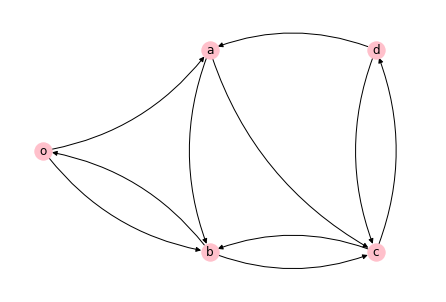

In [4]:
%matplotlib inline

G = nx.DiGraph()
G.add_edges_from([('o','a'),('o','b'),('b','o'),('a','b'),('a','c'),('c','b'),('b','c'),('c','d'),('d','c'),('d','a')])

pos = {'o': [0,2], 'a': [2,4], 'c': [4,0], 'b': [2,0], 'd': [4,4] }

nx.draw(G,pos, with_labels = True,  connectionstyle='arc3,rad = 0.2',node_color='pink')

**a) What is, according to the simulations, the average time it takes a particle that starts in node
a to leave the node and then return to it?**

To solve the problem we adopt the follow approach:
1. I have defined a unique global Poisson clock with rate  $\omega^* = \max_i(\omega_i)$  where $\omega_i= \sum_j \Lambda_{ij}$
2. When the Poisson clock ticks the particle can jump to a neighbor j with probability  $Q_{ij} = \frac{\Lambda_{ij}}{\omega^*}, \; i \neq j$ or remain in the same node with probability  $Q_{ii} = 1 - \sum_{i \neq j} Q_{ij}$.

In [5]:
#first compute the rate and the maximum rate
w = np.sum(A, axis=1)
w_star = np.max(w)
#compute the matrix of all the probability
Q=A/w_star
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))

In [6]:
print(Q)

[[0.4        0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.33333333 0.         0.33333333 0.33333333]]


Given the state space $\mathcal{X} = \{o, a, b, c, d\}$ we have to calculate the probability distribution $\bar{\pi}(t)$ of the CTMC $X(t)$ with transition matrix $\Lambda$.

$$
\bar{\pi}_i(t) = \mathbb P(X(t) = i), \quad i \in \mathcal X \,.
$$


To simulate a rate-r Poisson process, one can simulate the time $t_{next}$ between two
ticks of the Poisson clock, which is a random variable with rate-r exponential distribution. The time is calculate in the follow way:

$$
t_{next}=\frac{-ln(u)}{r}=\frac{-ln(u)}{\omega^*}
$$

Where u is a uniformly distributed random variable U(0, 1)

In [7]:
def sim(node_in,node_fin):
    pos = [] #this variable is used to take trace of the nodes that are visited
    pos.append(node_in) #start from a
    t_t = [] #take trace of the time in which we have the jump
    t_t.append(0)
    t_next = -np.log(np.random.rand())/w_star #np.random.rand() return number between 0,1
    n_s= 5 #n° of nodes
    if node_in==node_fin:
        while len(list(filter(lambda x: x == node_in, pos)))!=2:#until we retun in a 
                       #int -> the random sample is generated as if it were np.arange(a)
            next_pos = np.random.choice(n_s, p=Q[pos[-1],:])#vector of probability 
                                               #the probabilities for the last node (in pos) to jumb to the other nodes
            pos.append(next_pos)
            next_trans_time = t_t[-1] + t_next
            t_t.append(next_trans_time)
            t_next = -np.log(np.random.rand())/w_star
        return t_t[-1]
    else:
        while pos[len(pos)-1]!=node_fin:
            next_pos = np.random.choice(n_s, p=Q[pos[-1],:])
            pos.append(next_pos)
            next_trans_time = t_t[-1] + t_next
            t_t.append(next_trans_time)
            t_next = -np.log(np.random.rand())/w_star
        return t_t[-1]

now I’m going to simulate the path made by the particle 100000 times and after that I calculate the average time

In [8]:
tot =[]
for i in range(100000):
    tot.append(sim(1,1))
    
avg_time = sum(tot)/100000  
    

In [9]:
print(avg_time)

6.734233991516696


**b) How does the result in a) compare to the theoretical return-time ${\mathbb{E}}_a[T_a^{+}]$ ?(Include a description of how this is computed.)**

To calculate the expected return time I used the following formula:
$$
{\mathbb{E}}_a[T_a^{+}]= \frac{1}{\pi_a} = \frac{1}{\bar{\pi}_a \omega_a}
$$

In [10]:
values,vectors = np.linalg.eig(Q.T) #compute eigenvalues and eigenvector
print(values.real)
index = np.argmax(values.real)# find the maximum eigenvalue (0)
pi = vectors[:,index].real
pi_bar = pi/np.sum(pi)
print("pi_bar=", pi_bar)
return_time = 1/(pi_bar[1]*w[1])
print("return time=", return_time)

[ 1.          0.54505216 -0.09869205 -0.09869205 -0.61433473]
pi_bar= [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]
return time= 6.750000000000004


**c) What is, according to the simulations, the average time it takes to move from node o to node
d?**

In [11]:
tot =[]
for i in range(100000):
    tot.append(sim(0,4))
    
avg_time = sum(tot)/100000

In [12]:
print(avg_time)

8.790488470958811


**d) How does the result in c) compare to the theoretical hitting-time ${\mathbb{E}}_o[T_d^{+}]$? (Describe also how this is computed.)**

The following formula has been used to calculate the hitting time:
$$
{\mathbb{E}}_o[T_S] = \frac{1}{\omega_o} + \sum_{ j} P_{oj}{\mathbb{E}}_j[T_S]
$$
where $S \subseteq V$ and $V=\{d\}$

To obtain $\frac{1}{\omega_o} + \sum_{ j} P_{oj}{\mathbb{E}}_j[T_S]$ we consider $R =V \backslash S $ and $Q = P_{|R x R}, \tau \in \mathbb{R}^{R} $

$\tau = \frac{\mathbb{1}}{\omega} + Q\tau  \Longleftrightarrow (I-Q)\tau = \frac{\mathbb{1}}{\omega} \Longleftrightarrow \tau = (I-Q)^{-1}\frac{\mathbb{1}}{\omega}$


$(I-Q)$ is invertible because $V \backslash S$  has a link pointing to S

In [13]:
#first remove row and column associated to (V) d from Q 
P =np.linalg.inv(np.diag(w[0:4]))@(np.array(A)[:4,:4])
print(P)
I = np.identity(4)
onesw =1 / w[0:4]
tau = np.linalg.inv(I-P) @ (1 / w[0:4])
print(tau)

[[0.         0.66666667 0.33333333 0.        ]
 [0.         0.         0.75       0.25      ]
 [0.5        0.         0.         0.5       ]
 [0.         0.         0.33333333 0.        ]]
[8.78571429 7.14285714 7.07142857 3.35714286]


The result is the vector of the times that the different nodes take to get to d, so to go from o to d  the theoretical hitting-time is equal to 8.78.

**e) Interpret the matrix $\Lambda$ as the weight matrix of a graph G = (V, E, $\Lambda$), and simulate the French-DeGroot dynamics on G with an arbitrary initial condition x(0). Does the dynamics converge to a consensus state? Motivate your answer.**


In [14]:
#define an arbitrary inital condition 
degrees = np.sum(np.array(A),axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ np.array(A)
#print(P)
x = [23, 5, 76, 500, 97]
res=np.array([23, 5, 76, 500, 97])
epoch =[0]

for n in range(50):
    x = P @ x
print("x(50):", x, "\n")

x = [23, 5, 76, 500, 97] #reset every time the initial condition

for n in range(100):
    x = P @ x
print("x(100):", x, "\n")

x = [23, 5, 76, 500, 97]

for n in range(200):
    x = P @ x
    res =np.vstack((res,x.copy()))
    epoch.append(n+1)
print("x(200):", x, "\n")



x(50): [171.00000914 171.00017837 170.99962192 171.00057915 170.99951317] 

x(100): [171. 171. 171. 171. 171.] 

x(200): [171. 171. 171. 171. 171.] 



As we can see being the graph fully connected the dynamics converge to a consensus state immediately after a few iterations regardless of initial conditions


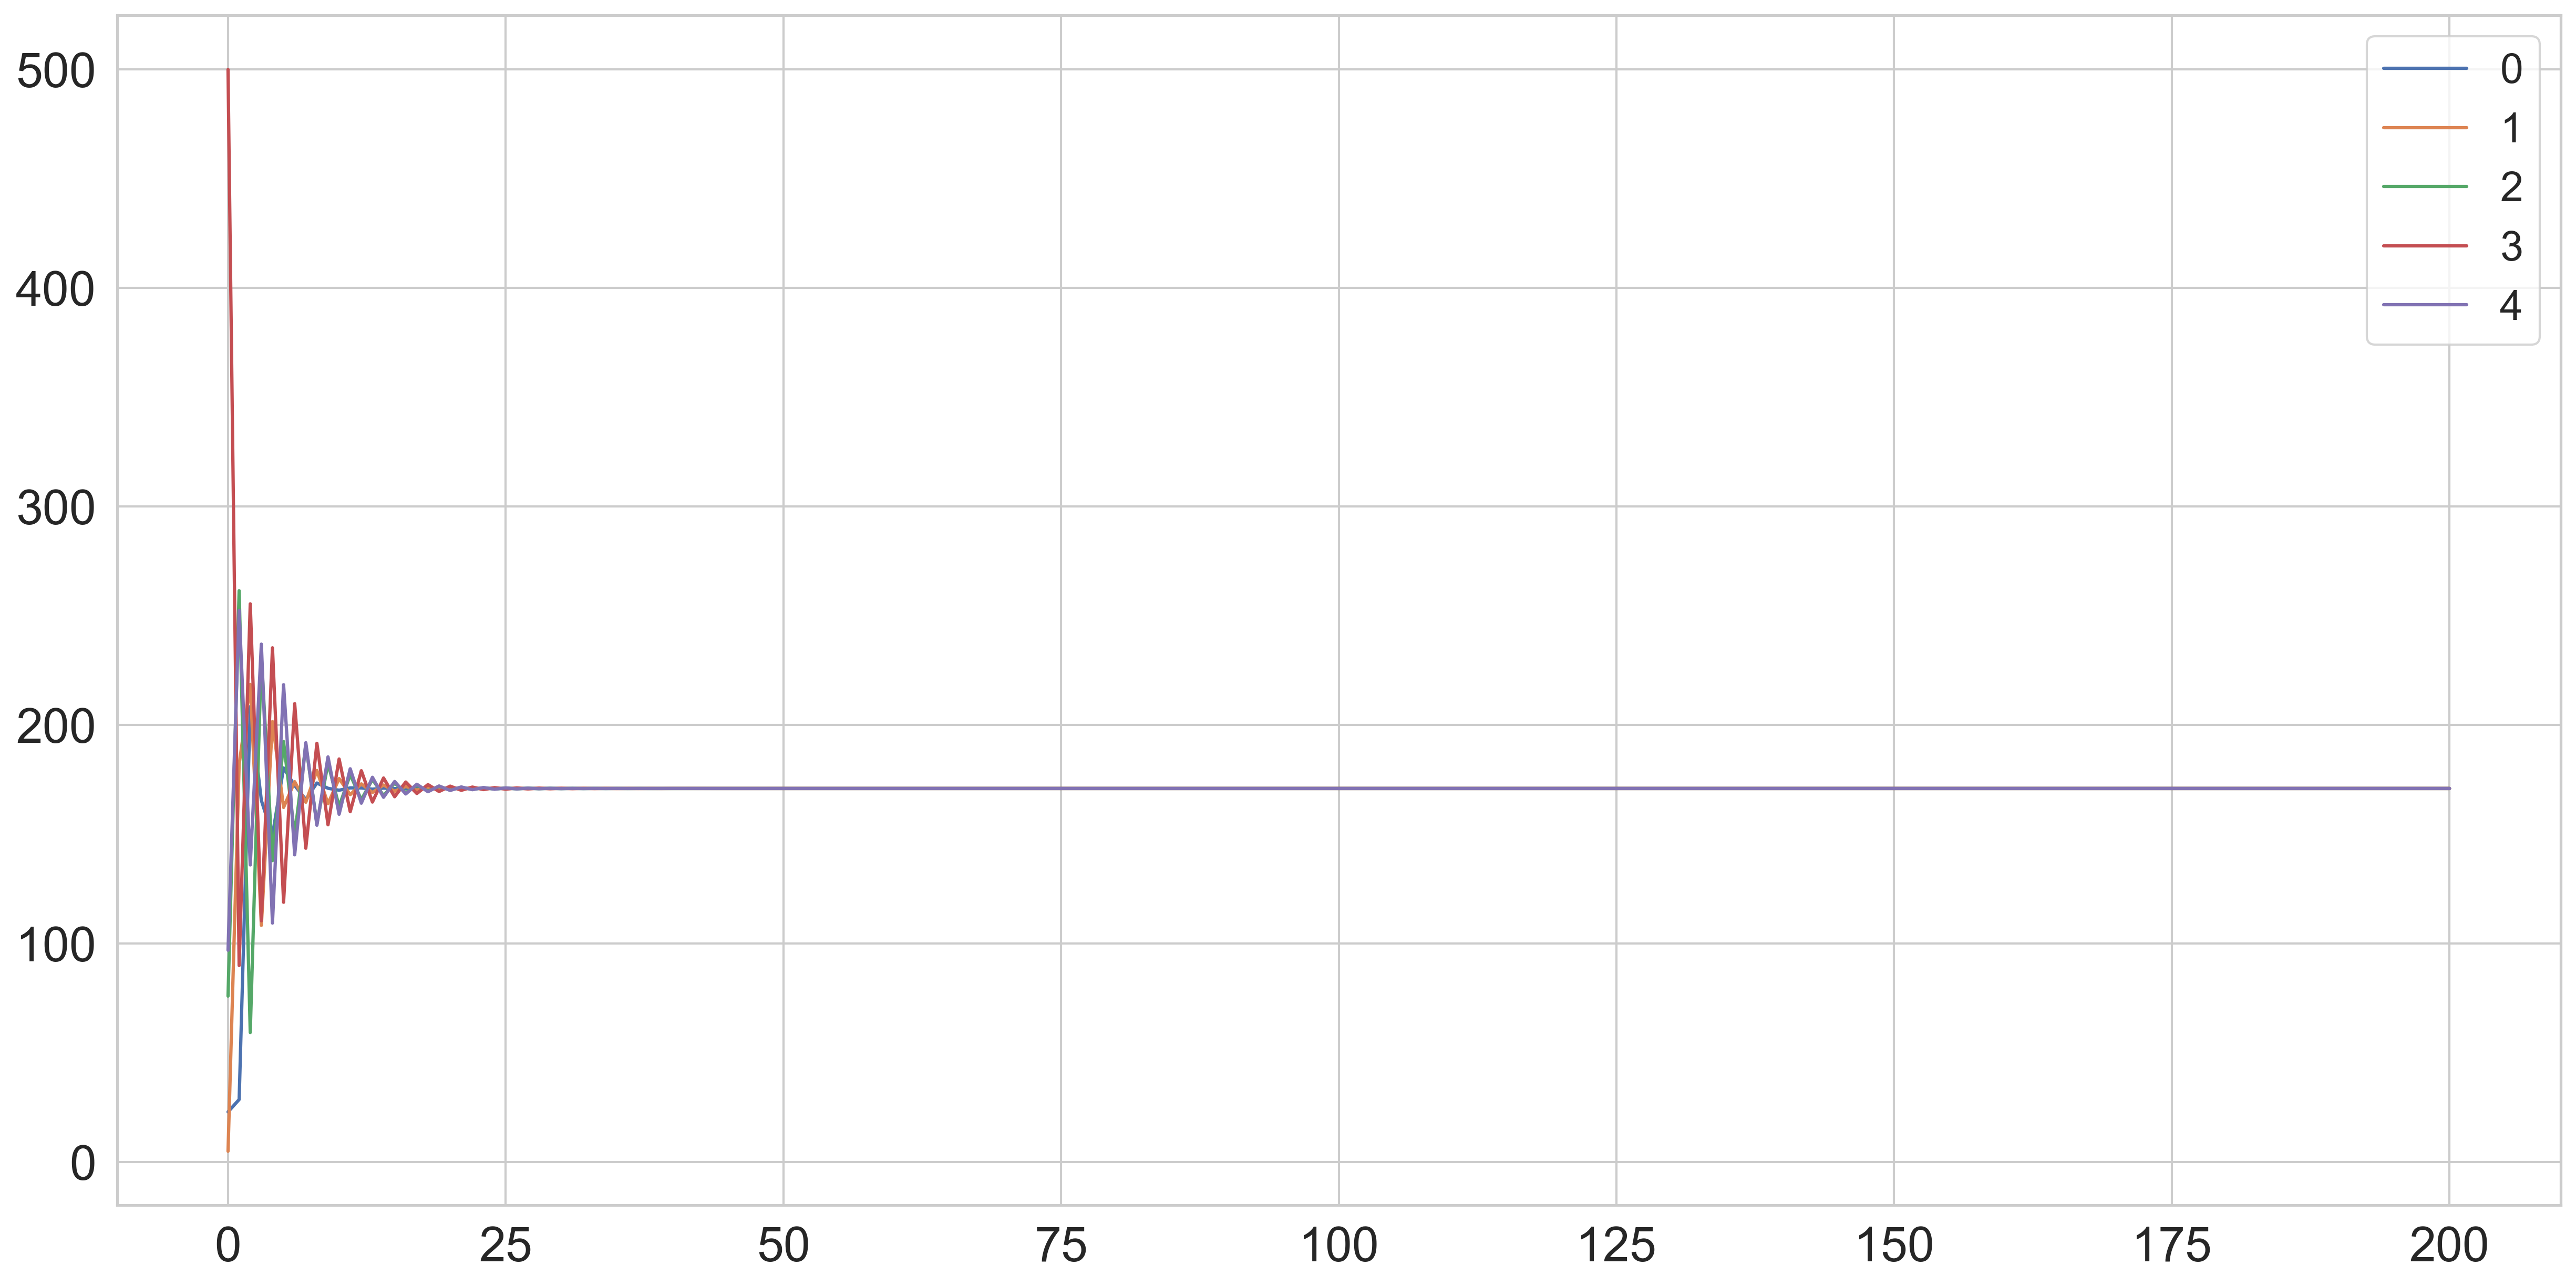

In [15]:
sim_rappr(res,epoch) 


**f) Assume that the initial state of the dynamics for each node $i \in V$ is given by $x_i(0) =\xi_i $, where $\{\xi_i\}_i \in V$ are i.i.d random variables with variance $\sigma^{2}$. Compute the variance of the consensus value, and compare your results with numerical simulations.**

I choose a uniform random variable that returns values in the range $[0,1]$ and then has an average of $\frac{1}{2}$ and a variance of $\frac{1}{12}$

In [16]:
values_P,vectors_P = np.linalg.eig(P.T) #compute eigenvalues and eigenvector
index_P = np.argmax(values_P.real)
pi_P = vectors[:,index].real
pi_P = pi_P/np.sum(pi_P)

err = np.zeros(300)
mean_rv=1/2
var_rv=1/12

for i in range(300):

    x = np.random.rand(5)
    var = np.var(x)#calculate var for each convergence of the consensus
    for n in range(500):
        x = P @ x
    err[i] = (1/2 - np.mean(x))*(1/2 - np.mean(x))
    

print("Variance of the consensus state:", np.mean(err), "\n")    
print("Variance theoretically calculated", (np.sum(pi_P**2))*var_rv)

Variance of the consensus state: 0.018387334265831636 

Variance theoretically calculated 0.01703246456332876


As you can see the value of the variance of the consent is different from the value of the variance of the single individual (1/12), this is normal since having a fully connected graph all opinions affect.
Note also that $\sum_{i} \pi_i^2$ is <<1 when the nodes have the same centrality (as in the complete graph, or in the cycle graph, contriubute in the same way). This implies that if a graph is more 'democratic', then the consensus algorithm leads to better estimates of the true state. If a few nodes have all the centralities, the consensus value is less reliable.

**f) Remove the edges (d, a) and (d, c). Describe and motivate the asymptotic behaviour of the
dynamics. If the dynamics converges to a consensus state, how is the consensus value related
to the initial condition x(0)? Assume that the initial state of the dynamics for each node
$i \in V$ is given by $x_i(0) =\xi_i $, where  $\{\xi_i\}_i \in V$ are i.i.d random variables with variance $\sigma^{2}$.Compute the variance of the consensus value. Motivate your answer.**

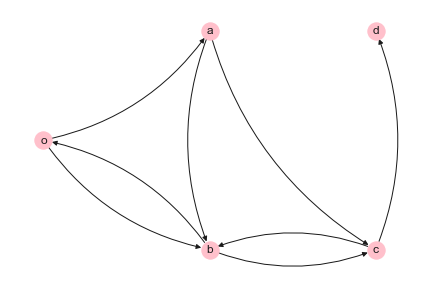

In [17]:
G.remove_edge("d","a")
G.remove_edge("d","c")
nx.draw(G,pos, with_labels = True, connectionstyle='arc3,rad = 0.2',node_color='pink')


Removing these two links we get that the starting graph is no longer strongly connected, but since in the graph there is now a single sink (ie a globally reachable connected component C0) which in our case is represented by d than:

$$\lim_{t \to + \infty} x_i(t)= \pi^{'}x(0)             $$ $$\forall i$$
And also the opinions of agents not belonging to the sink have no influence on the final consensus value, so the value of the consensus will depend only on d. So if we now try to simulate the dynamics with a certain condition we will see that the value converge to the one associated with d.

In [18]:
A =[[0,2/5,1/5,0,0],[0,0,3/4,1/4,0],[1/2,0,0,1/2,0],[0,0,1/3,0,2/3],[0,0,0,0,1]] 
#first we have to modify A and all the other component used to calcolate the consensu that depends on it
#i insert a loop on d to don't have a singular matrix -> so with determinant equal to 0 
degrees = np.sum(np.array(A),axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ np.array(A)

x = [37, 47, 1, 500, 63]
res=[37, 47, 1, 500, 63]
epoch= [0]

for n in range(50):
    x = P @ x
    res =np.vstack((res,x.copy()))
    epoch.append(n+1)
                   
print("x(50):", x, "\n")

x(50): [63.00713178 63.00593681 63.00574264 63.00232485 63.        ] 



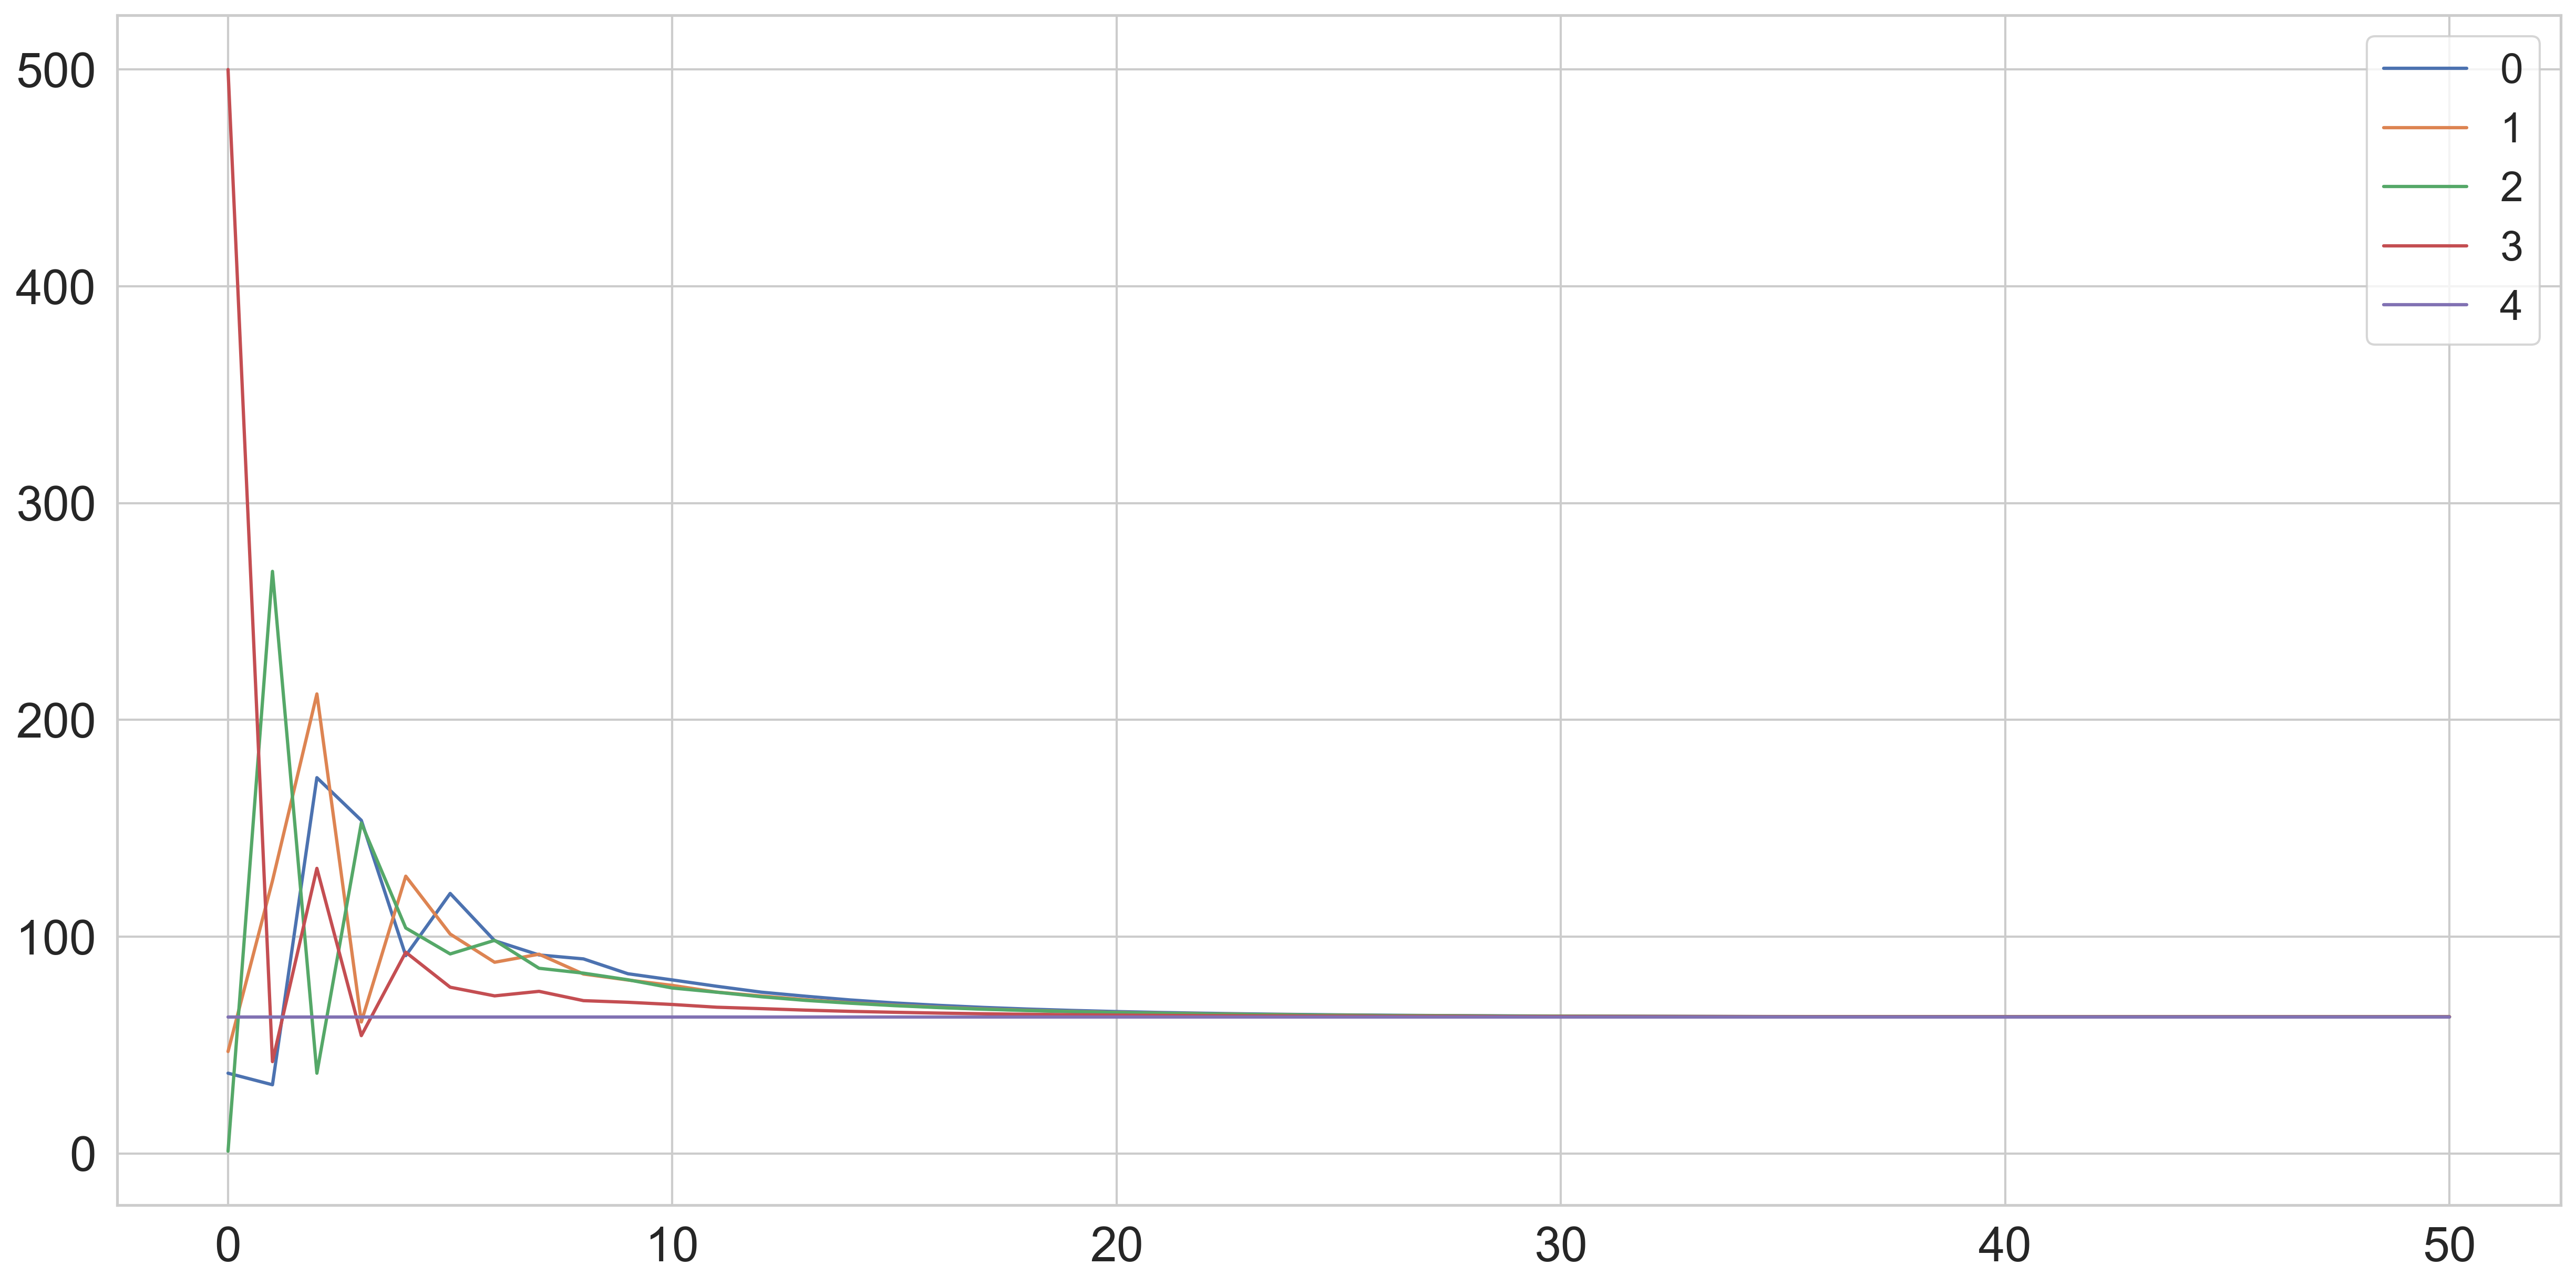

In [19]:
sim_rappr(res,epoch) 

As mentioned above it can be noted that the value of the convergence depends exclusively on the initial value of the sink component. Now let’s calculate the variance of the consensus value. To do this we will go back to consider five random variables i.i.d uniform with therefore average equal to $\frac{1}{2}$ and variance equal to $\frac{1}{12}$

Changing now the value of the initial allocation as in the previous exercise:

In [20]:
err_2 = np.zeros(300)

for i in range(300):
    x = np.random.uniform(size=5) 
    var = np.var(x) #calculate var for each convergence of the consensus
    for n in range(500):
        x = P @ x
    
    err_2[i] = (mean_rv - np.mean(x))*(mean_rv - np.mean(x))
print("Variance of the single variabe:", 1/12)
print("Variance of the consensus state:", np.mean(err_2), "\n")

Variance of the single variabe: 0.08333333333333333
Variance of the consensus state: 0.08803511631197437 



As can be seen now that in the graph there is a sink component the value of the variance of the consensus state is very close to that of the variance of the uniform variable. This is due to the fact that the consent converges to the value of the single variable linked to node d that being a random variable uniform has value $\frac{1}{12}$. While in the previous exercise it was far from this value because the value of the variance of the consensus was also influenced by the opinion of the other nodes.

**g) Consider the graph (V, E, $\Lambda$), and remove the edges (c, b) and (d, a). Analyse the French-DeGroot dynamics on the new graph. In particular, describe and motivate the asymptotic
behaviour of the dynamics in terms of the initial condition x(0).**

In [21]:
G.remove_edge("c","b")
G.add_edge("d","c")

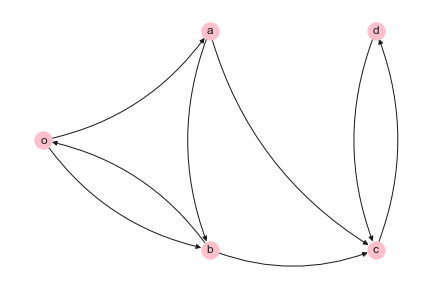

In [22]:
nx.draw(G,pos, with_labels = True, connectionstyle='arc3,rad = 0.2',node_color='pink')

In [23]:
A =[[0,2/5,1/5,0,0],[0,0,3/4,1/4,0],[1/2,0,0,1/2,0],[0,0,0,0,2/3],[0,0,0,1/3,0]]

degrees = np.sum(np.array(A),axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ np.array(A)

x = [37, 47, 1, 500, 63]
res=[37, 47, 1, 500, 63]
epoch= [0]

for n in range(300):
    x = P @ x
    res =np.vstack((res,x.copy()))
    epoch.append(n+1)
print("x(300):", x, "\n")

x(300): [298.30769231 315.11538462 163.84615385 500.          63.        ] 



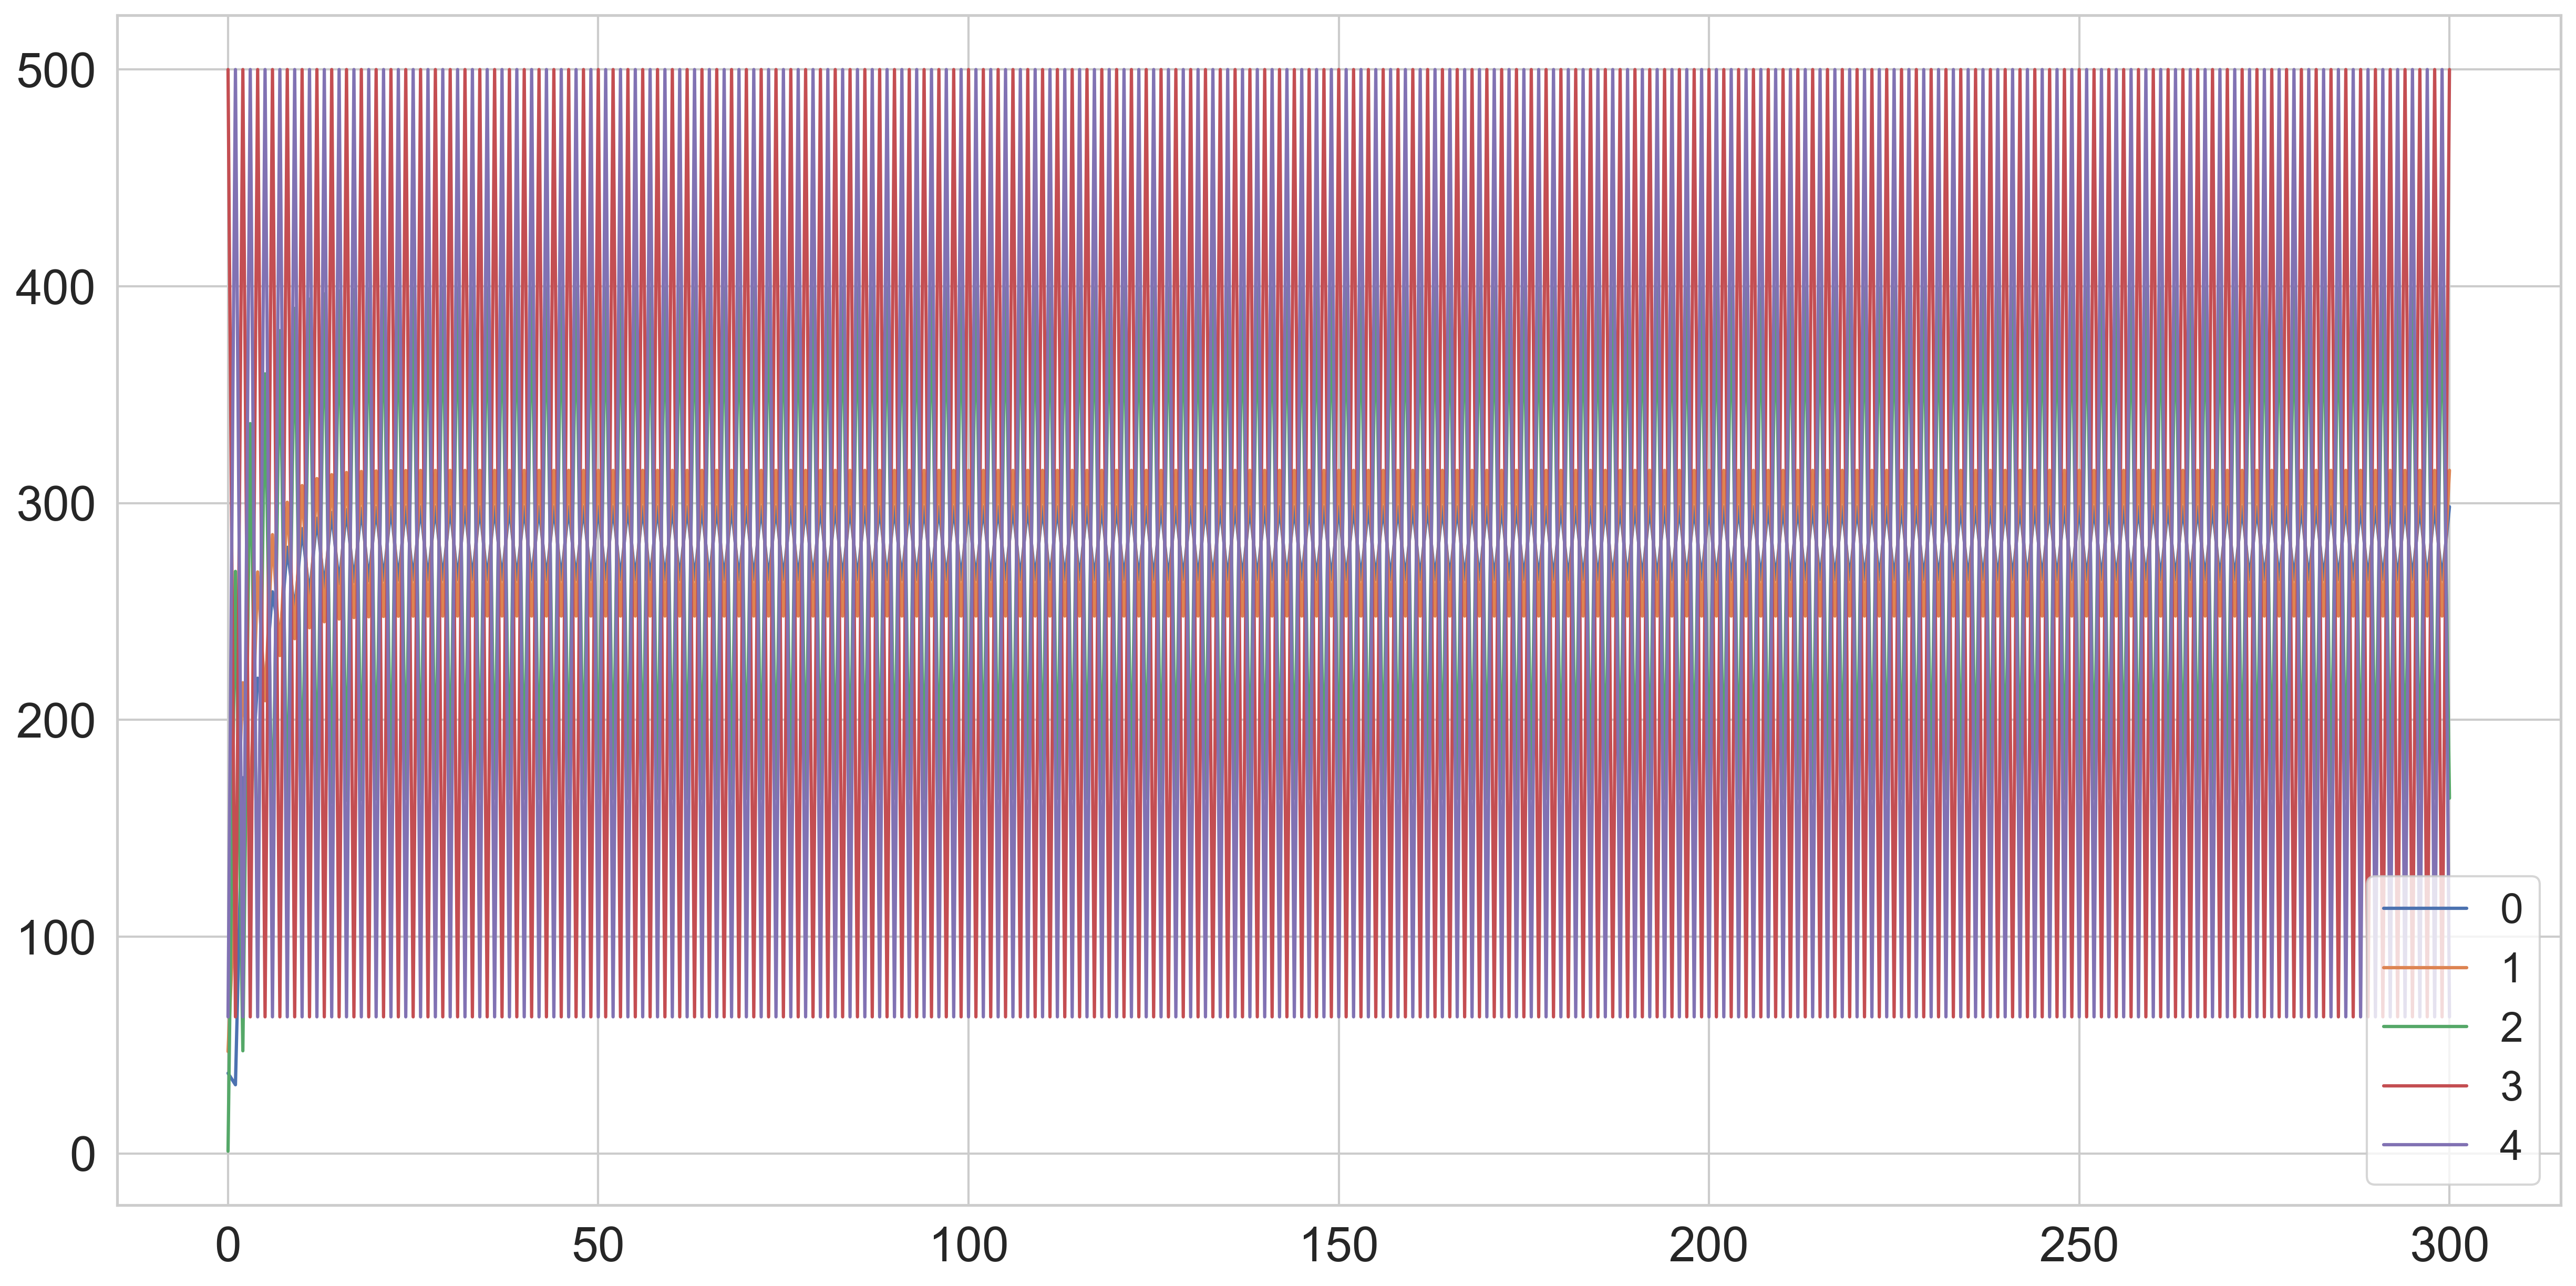

In [24]:
sim_rappr(res,epoch)

In this case even if present only one sink component the dynamics does not converge to a state of consent, this is due to the fact that the sink component is periodic. Consequently inside the sink component there will never be a convergence of opinion but each node inside it will keep its own opinion, this means that the nodes outside the sink component will not converge to a single value

# Exercise 2

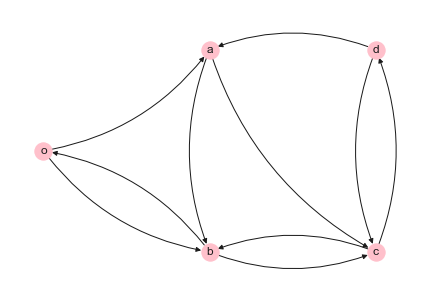

In [25]:
G.add_edge("c","b")
G.add_edge("d","a")
nx.draw(G,pos, with_labels = True, connectionstyle='arc3,rad = 0.2',node_color='pink')

**a) Particle perspective: If 100 particles all start in node a, what is the average time for a particle to return to node a? How does this compare to the answer in Problem 1, why?**

In [26]:
A =[[0,2/5,1/5,0,0],[0,0,3/4,1/4,0],[1/2,0,0,1/2,0],[0,0,1/3,0,2/3],[0,1/3,0,1/3,0]]
w = np.sum(A, axis=1)
w_star = np.max(w)
#compute the matrix of all the probability
Q=A/w_star
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))

In [27]:
def sim2(node_in,node_fin):
    pos = [] #this variable is used to take trace of the nodes that are visited
    t_t = [] #take trace of the time in which we have the jump
    for i in range(100): #to simulate the start in a i create a vector of 100 particles all starting in a
        pos.append([1])
        t_t.append([0])
    n_s=5   
    c=[]
    tot=0
    while len(c)!=100: #until all particles are returned to a, that is, until the vector checking the last position whether in a or not, returns everything to True
                                       
            for i in range(len(pos)):
                if(len(pos[i])==1 or pos[i][-1]!=1): #don’t keep moving if you’re already back in a
                    
                    next_pos = np.random.choice(n_s, p=Q[pos[i][-1],:])#vector of the probabilities associated with each node in which it can jump
                    t_next = -np.log(np.random.rand())/w_star#global clock
                    pos[i].append(next_pos)
                    next_trans_time = t_t[i][-1] + t_next
                    t_t[i].append(next_trans_time)
            c=[True for x in pos if x[-1]==1]        
    
    
    for i in t_t:
        tot+=i[-1]    
    return t_t,pos,c,tot/100

In [28]:
t,p,c,res=sim2(1,1)
res

5.885524313367899

In [29]:
tot =[]
for i in range(100):
    t,p,c,res=sim2(1,1)
    tot.append(res)
    
avg_time = sum(tot)/100

In [30]:
avg_time

6.687827546719603

For the simulation I decided to simulate the movement of the particles as single attaching to each to Poisson clock. The result obtained is the same obtained in the previous exercise, when to move was a single particle. This is because the movement of particles is independent of what others do.


**b) Node perspective:**

**If 100 particles start in node o, and the system is simulated for 60 time units, what is
the average number of particles in the different nodes at the end of the simulation?**

In [31]:
def sim3(node_in):
    pos = [] #this variable is used to take trace of the nodes that are visited
    t_t = [] #take trace of the time in which we have the jump
    pos.append(node_in)
    t_t.append(0)
    n_s=5   
   
    n_p=np.array([100,0,0,0,0])#now all particles are considered together
    sim_over_time=np.array([100,0,0,0,0])#keeps track of the number of particles in each node at each iteration
    
    while t_t[-1]<60:
                                       
            from_pos = np.random.choice(n_s,p=n_p/100)#I choose the position from which the particle starts based on the number of particles present in a node
            pos.append(from_pos)        
            next_pos = np.random.choice(n_s, p=Q[pos[len(pos)-1],:])
            n_p[from_pos]-=1
            n_p[next_pos]+=1
            t_next = -np.log(np.random.rand())/(w_star*100)
            
            next_trans_time = t_t[-1] + t_next
            t_t.append(next_trans_time)  
            sim_over_time = np.vstack((sim_over_time,n_p.copy()))

    return n_p,sim_over_time,t_t

In [32]:
res,s_o_t,t_t=sim3(0)
res

array([17,  6, 23, 30, 24])

In [33]:
print(s_o_t)

[[100   0   0   0   0]
 [100   0   0   0   0]
 [100   0   0   0   0]
 ...
 [ 18   6  22  29  25]
 [ 18   6  22  30  24]
 [ 17   6  23  30  24]]


In [34]:
res,s_o_t,t_t=sim3(0)
end =np.array(res)
for i in range(100): #simulate the experiment 100 times
    res,s_o_t,t_t=sim3(0)
    end = np.vstack((end,res.copy()))
    

In [35]:
avg_node_end = []
for i in range(6):
    x = sum(end[:,:i])/100
    avg_node_end.append(x)

After simulating the experiment 100 times, below is the average made on the number of particles at the end of each experiment

In [36]:
print(avg_node_end[-1])

[19.5  15.03 21.91 22.42 22.14]


**Illustrate the simulation above with a plot showing the number of particles in each node during the simulation time.**

In [37]:
print(s_o_t)

[[100   0   0   0   0]
 [ 99   1   0   0   0]
 [ 98   2   0   0   0]
 ...
 [ 19  10  17  32  22]
 [ 19  10  17  32  22]
 [ 19  10  17  32  22]]


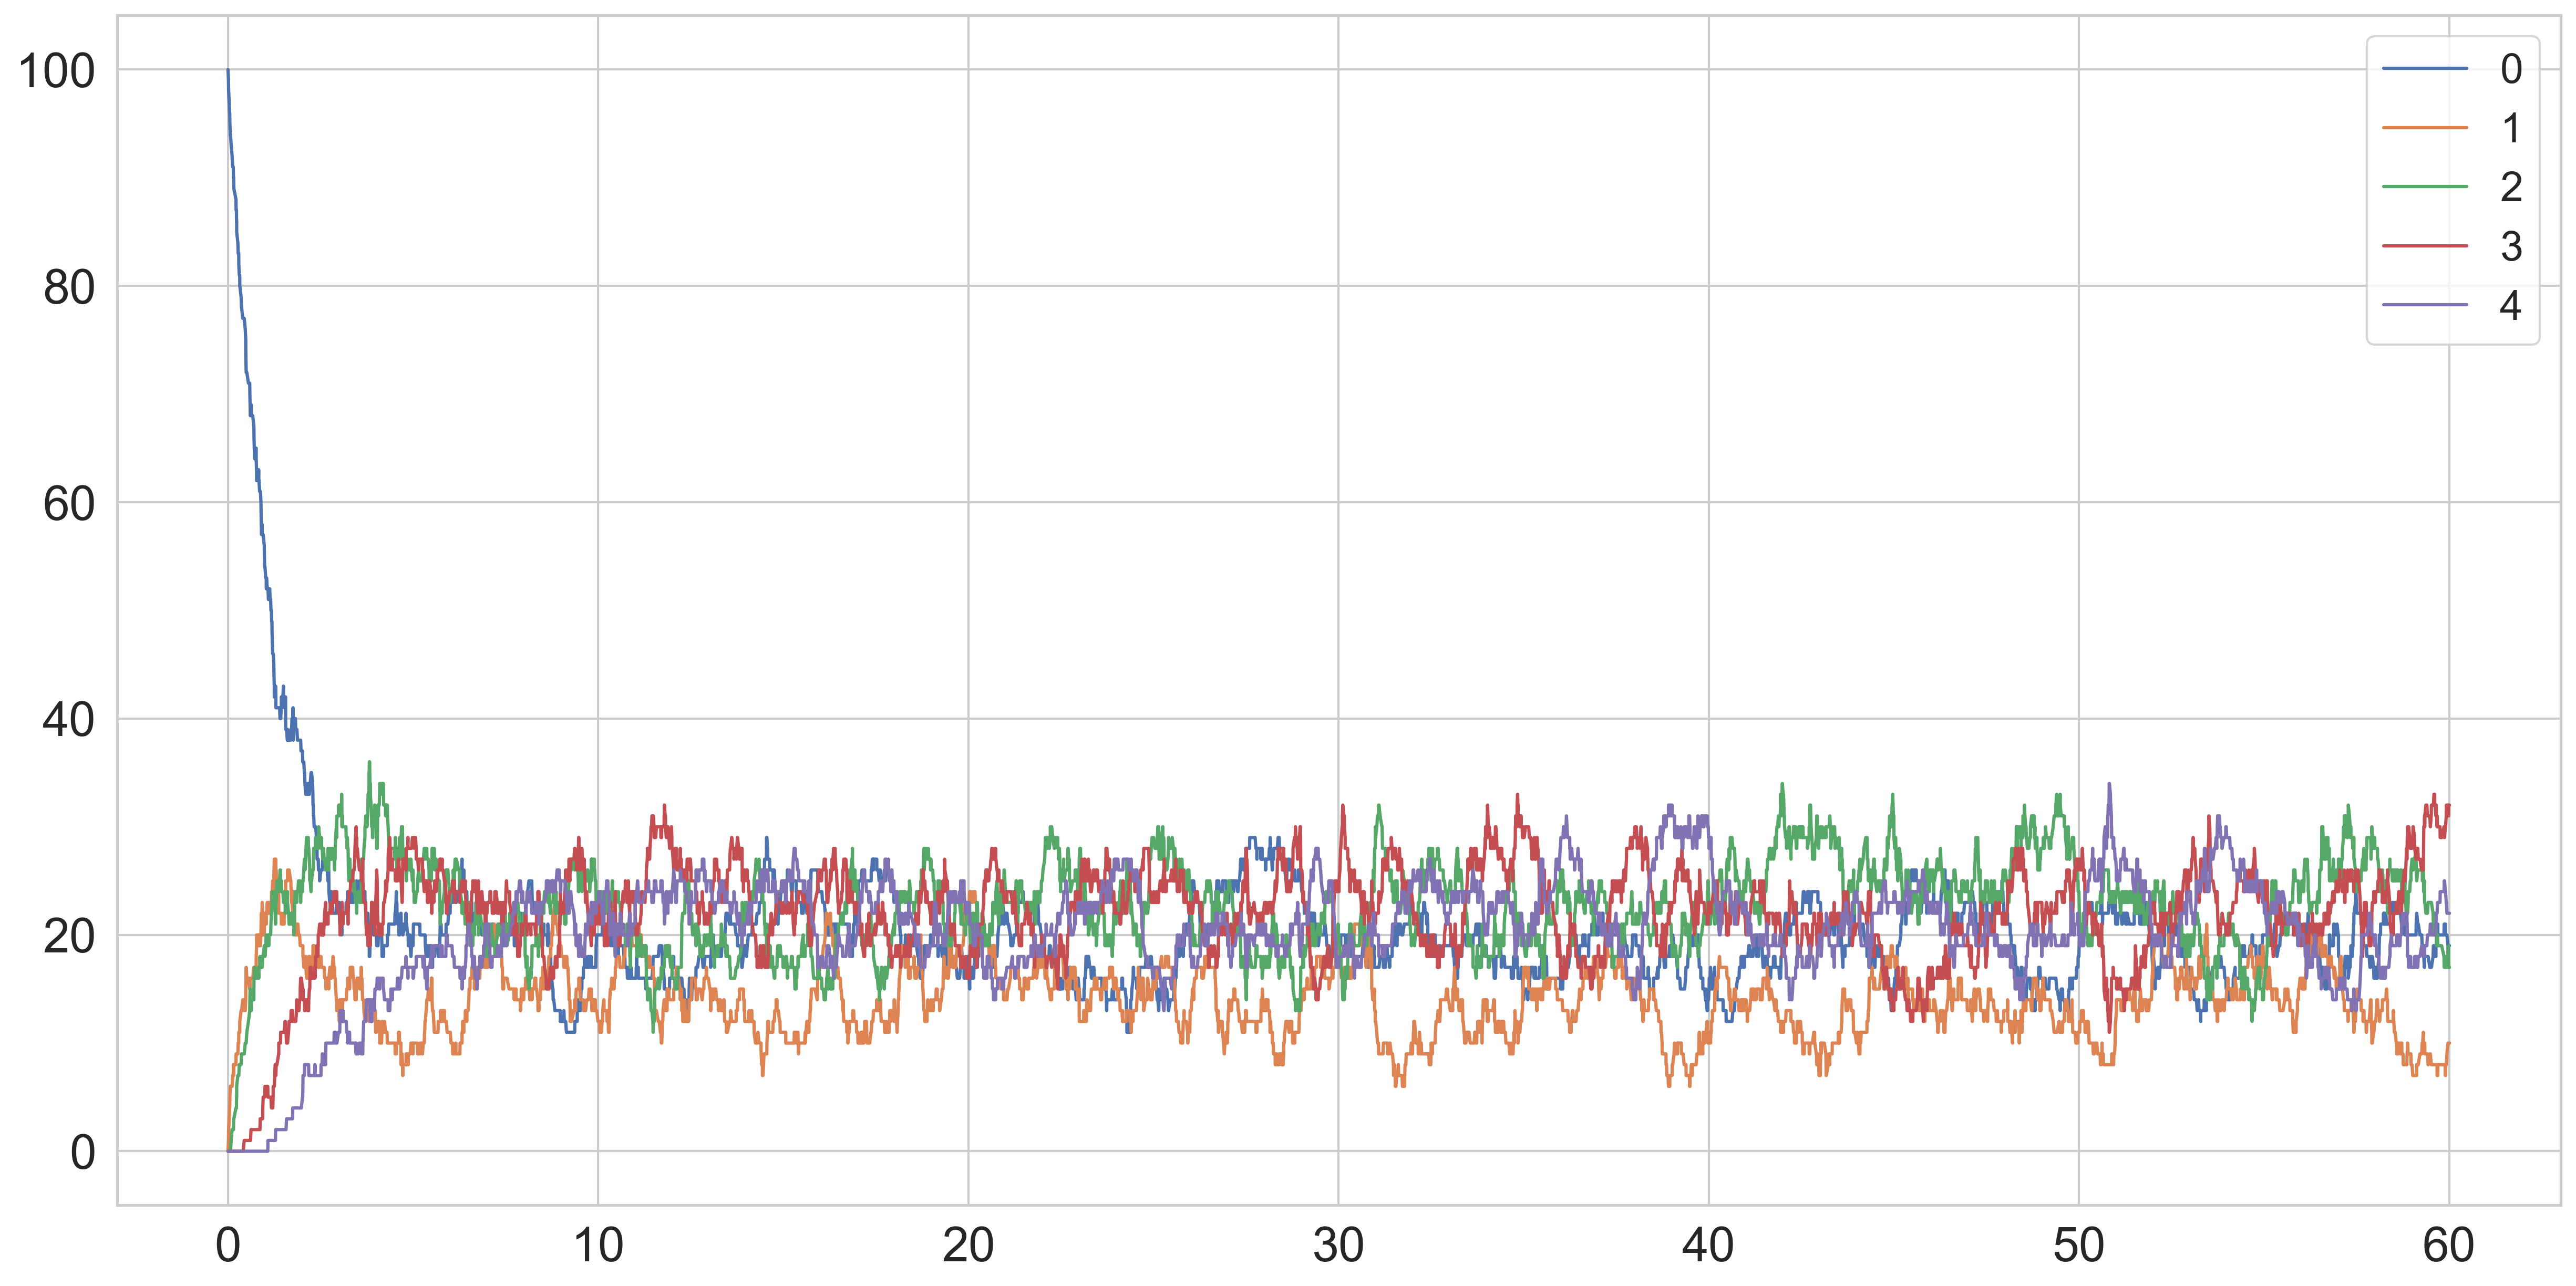

In [38]:
sim_rappr(s_o_t,t_t)

**Compare the simulation result in the first point above with the stationary distribution of the  continuous-time random walk followed by the single particles.**

The empirical frequencies are the fractions of total walk time that each node of the
graph is visited in the random walk. In order to use empirical frequencies to approximate
the invariant distribution of the graph, a random walk is constructed. the greater the number
of iterations made, the more accurate the approximation will be

# Exercise 3

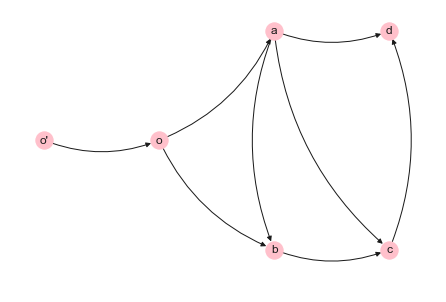

In [39]:
G2 = nx.DiGraph()
G2.add_edges_from([("o'",'o'),('o','a'),('o','b'),('a','b'),('a','c'),('a','d'),('b','c'),('c','d')])
pos = {"o'":[-2,2],'o': [0,2], 'a': [2,4], 'c': [4,0], 'b': [2,0], 'd': [4,4] }
nx.draw(G2,pos, with_labels = True, connectionstyle='arc3,rad = 0.2',node_color='pink')

**a) Proportional rate:**

**Simulate the system for 60 time units and plot the evolution of the number of particles
in each node over time.
What is the largest input rate that the system can handle without blowing up? (Poisson process with rate equal to the number of particles in the node times the rate of the local Poisson clock of node i)**

To simulate the system I decided to add a node (o') before o pointing to that latter, from which the particles that will then enter the system.
I also considered the case where the particle starts from node d, and in this case the particle is removed from the system. In addition in the case in which the number of particles present in a node is equal to 0 we consider the clock time of that node equal to infinity because we cannot divide the uniform variable by a number equal to 0. After calculating all t_next times (time between two Poisson clocks) relative to all nodes, I selected the node with the least time, this will be the node from which the particle will start.

In [40]:
A =[[0,3/4,3/8,0,0],[0,0,1/4,1/4,2/4],[0,0,0,1,0],[0,0,0,0,1],[0,0,0,0,1]]
    #print(np.array(A))
w = np.sum(A, axis=1)
D = np.diag(w)
Q = np.linalg.inv(D) @ A
w[-1]=2

In [41]:
print(w)

[1.125 1.    1.    1.    2.   ]


In [42]:
print(A)

[[0, 0.75, 0.375, 0, 0], [0, 0, 0.25, 0.25, 0.5], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]]


In [43]:
def sim_proportional_fixed(input_rate, prop):
    t_t = [] #take trace of the time in which we have the jump
    t_t.append(0)
    n_s=5
    nodes = range(n_s)
    part_in_circolo=1
    n_p=np.array([1,0,0,0,0])#we start the simulation with a particle in o
    sim_over_time=np.array([1,0,0,0,0])
    
    while t_t[-1]<60:
            
            find_min =[]
            for i in range(n_s):
                    if(n_p[i]==0):
                        t_next = float('Inf')#if the node does not contain particles its next_time will be infinite
                    else:
                        if prop:
                            t_next = -np.log(np.random.rand())/(w[i]*n_p[i])#local clock associated to each node
                        else:
                            t_next = -np.log(np.random.rand())/(w[i])                          
                    find_min.append(t_next)
                    
            find_min.append(-np.log(np.random.rand())/input_rate)#time_next of o'    
            minimum = min(find_min) #the node from which you start is the one that clicks first 
            index = find_min.index(minimum)       
            from_pos = index
            
            
            if(from_pos not in nodes):#if the starting node is o' I add a particle in the system
                part_in_circolo+=1
                n_p[0]+=1
            elif(from_pos==nodes[-1]):#if the starting node is d remove a particle from the circle
                part_in_circolo-=1
                n_p[from_pos]-=1
            else: 
                next_pos = np.random.choice(n_s, p=Q[from_pos,:])
                n_p[from_pos]-=1
                n_p[next_pos]+=1 
           
            
            next_trans_time = t_t[-1] + minimum
            t_t.append(next_trans_time)  
            sim_over_time = np.vstack((sim_over_time,n_p.copy()))

    return n_p,sim_over_time,t_t

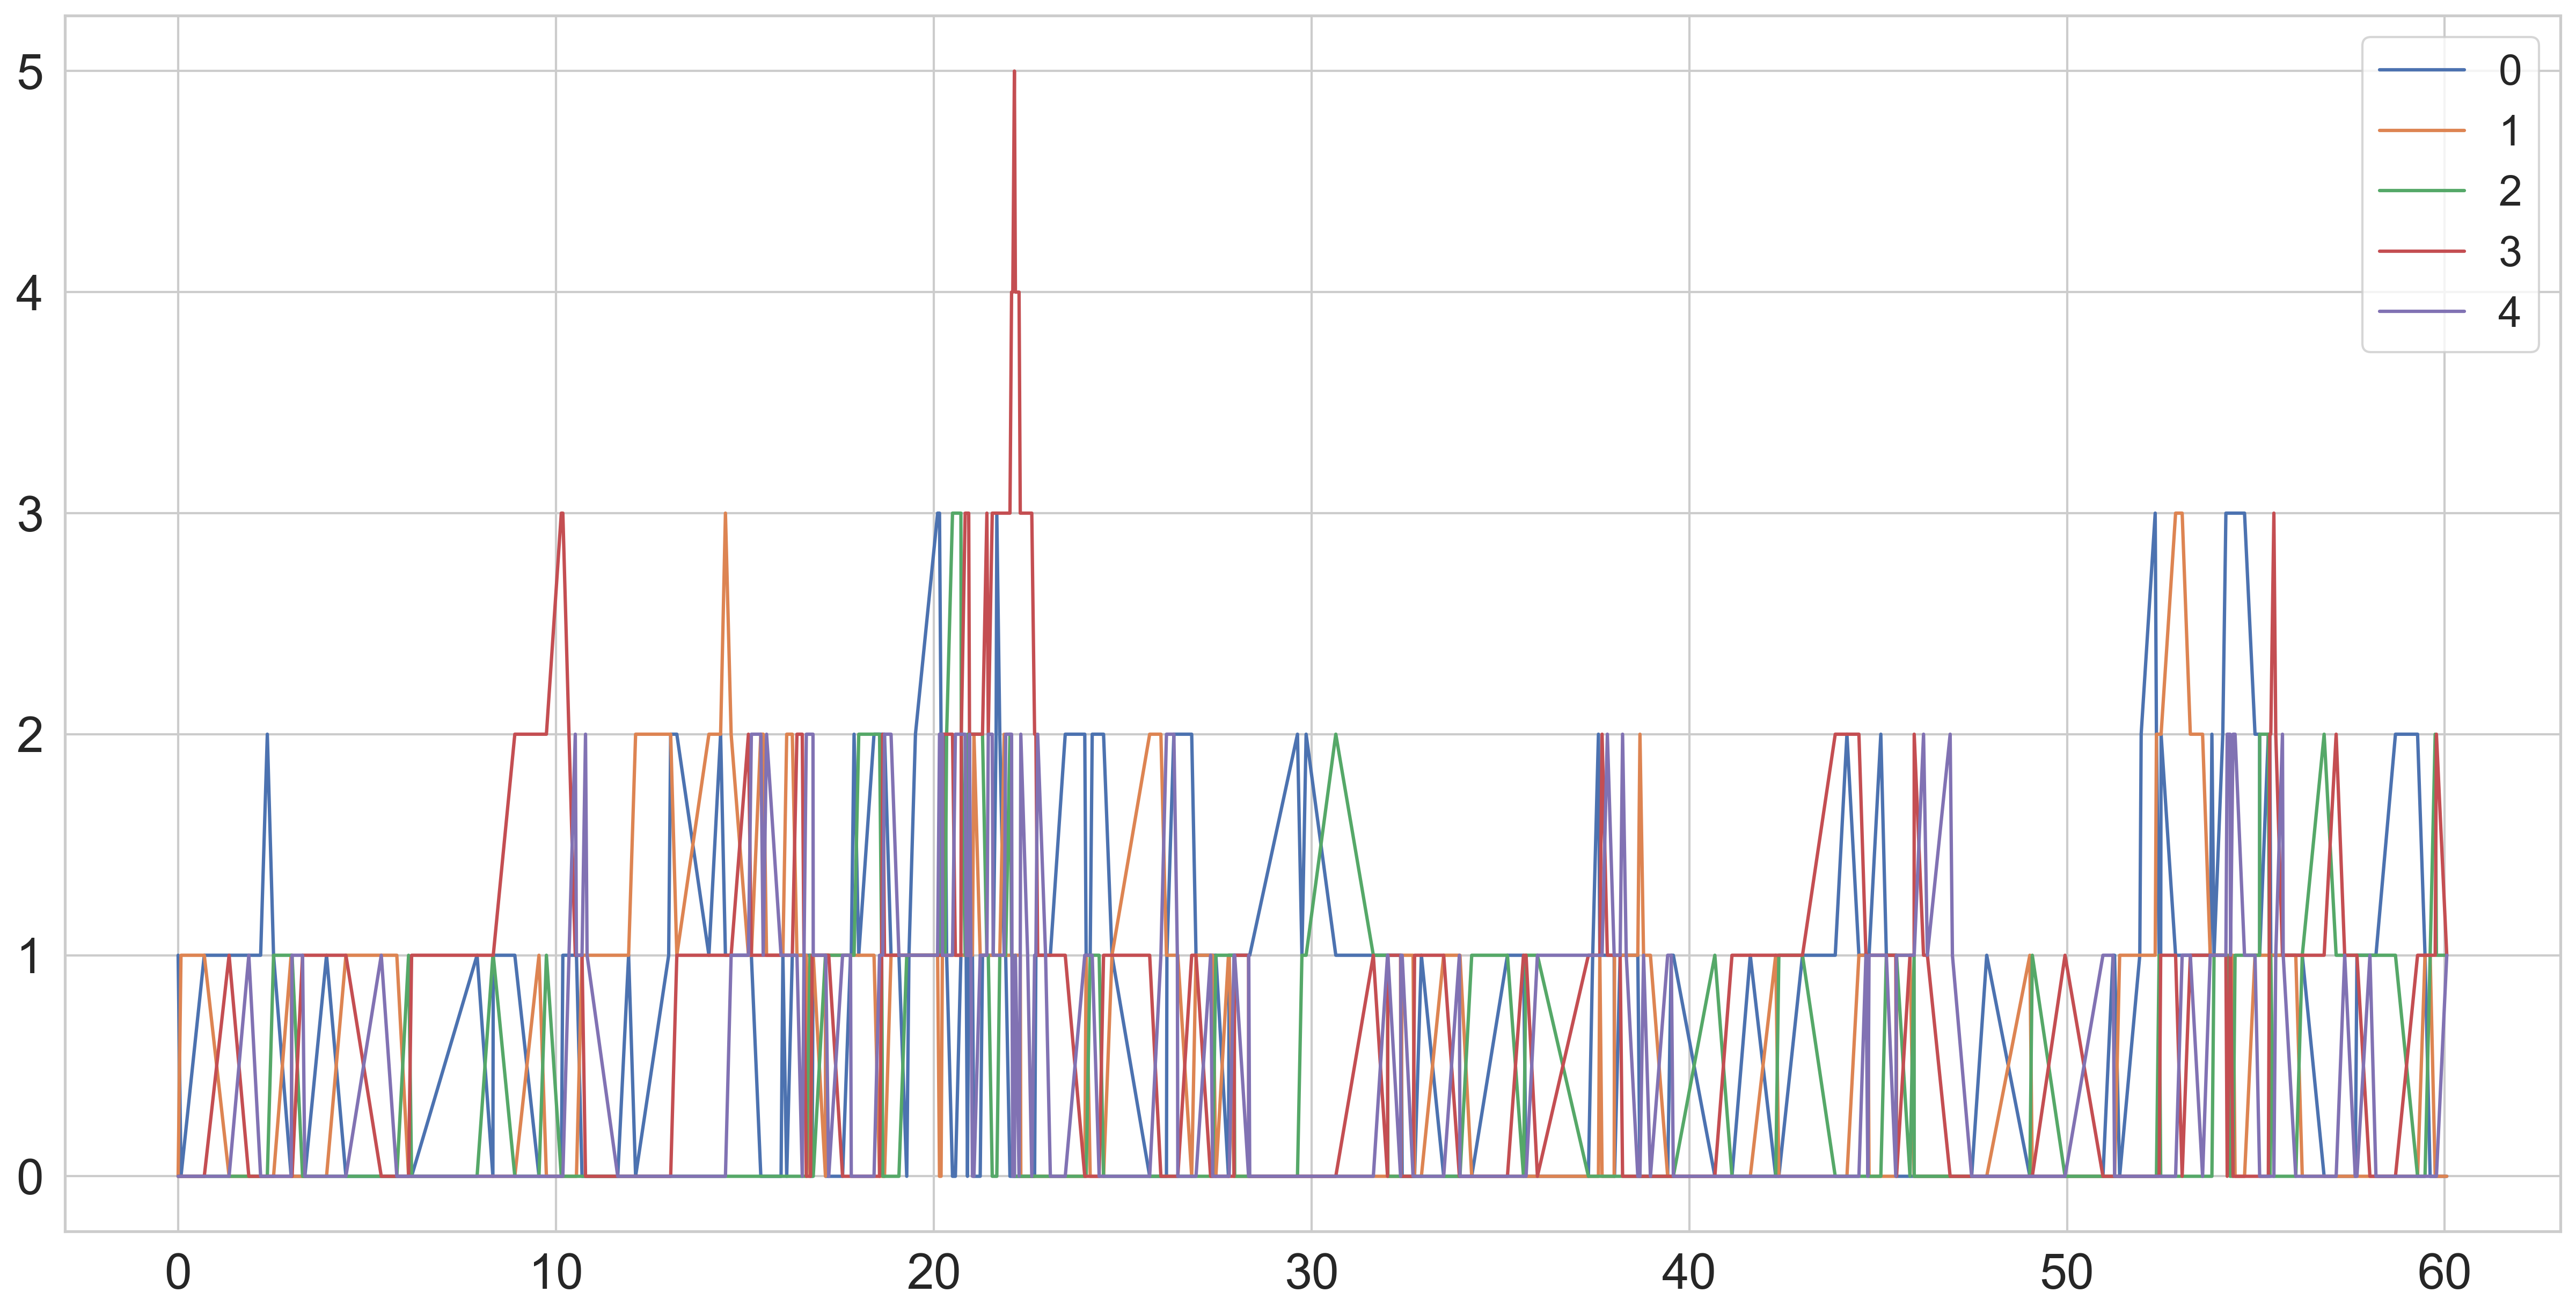

In [44]:
n_p,s_o_t,t_t= sim_proportional_fixed(1, True)
sim_rappr(s_o_t,t_t)

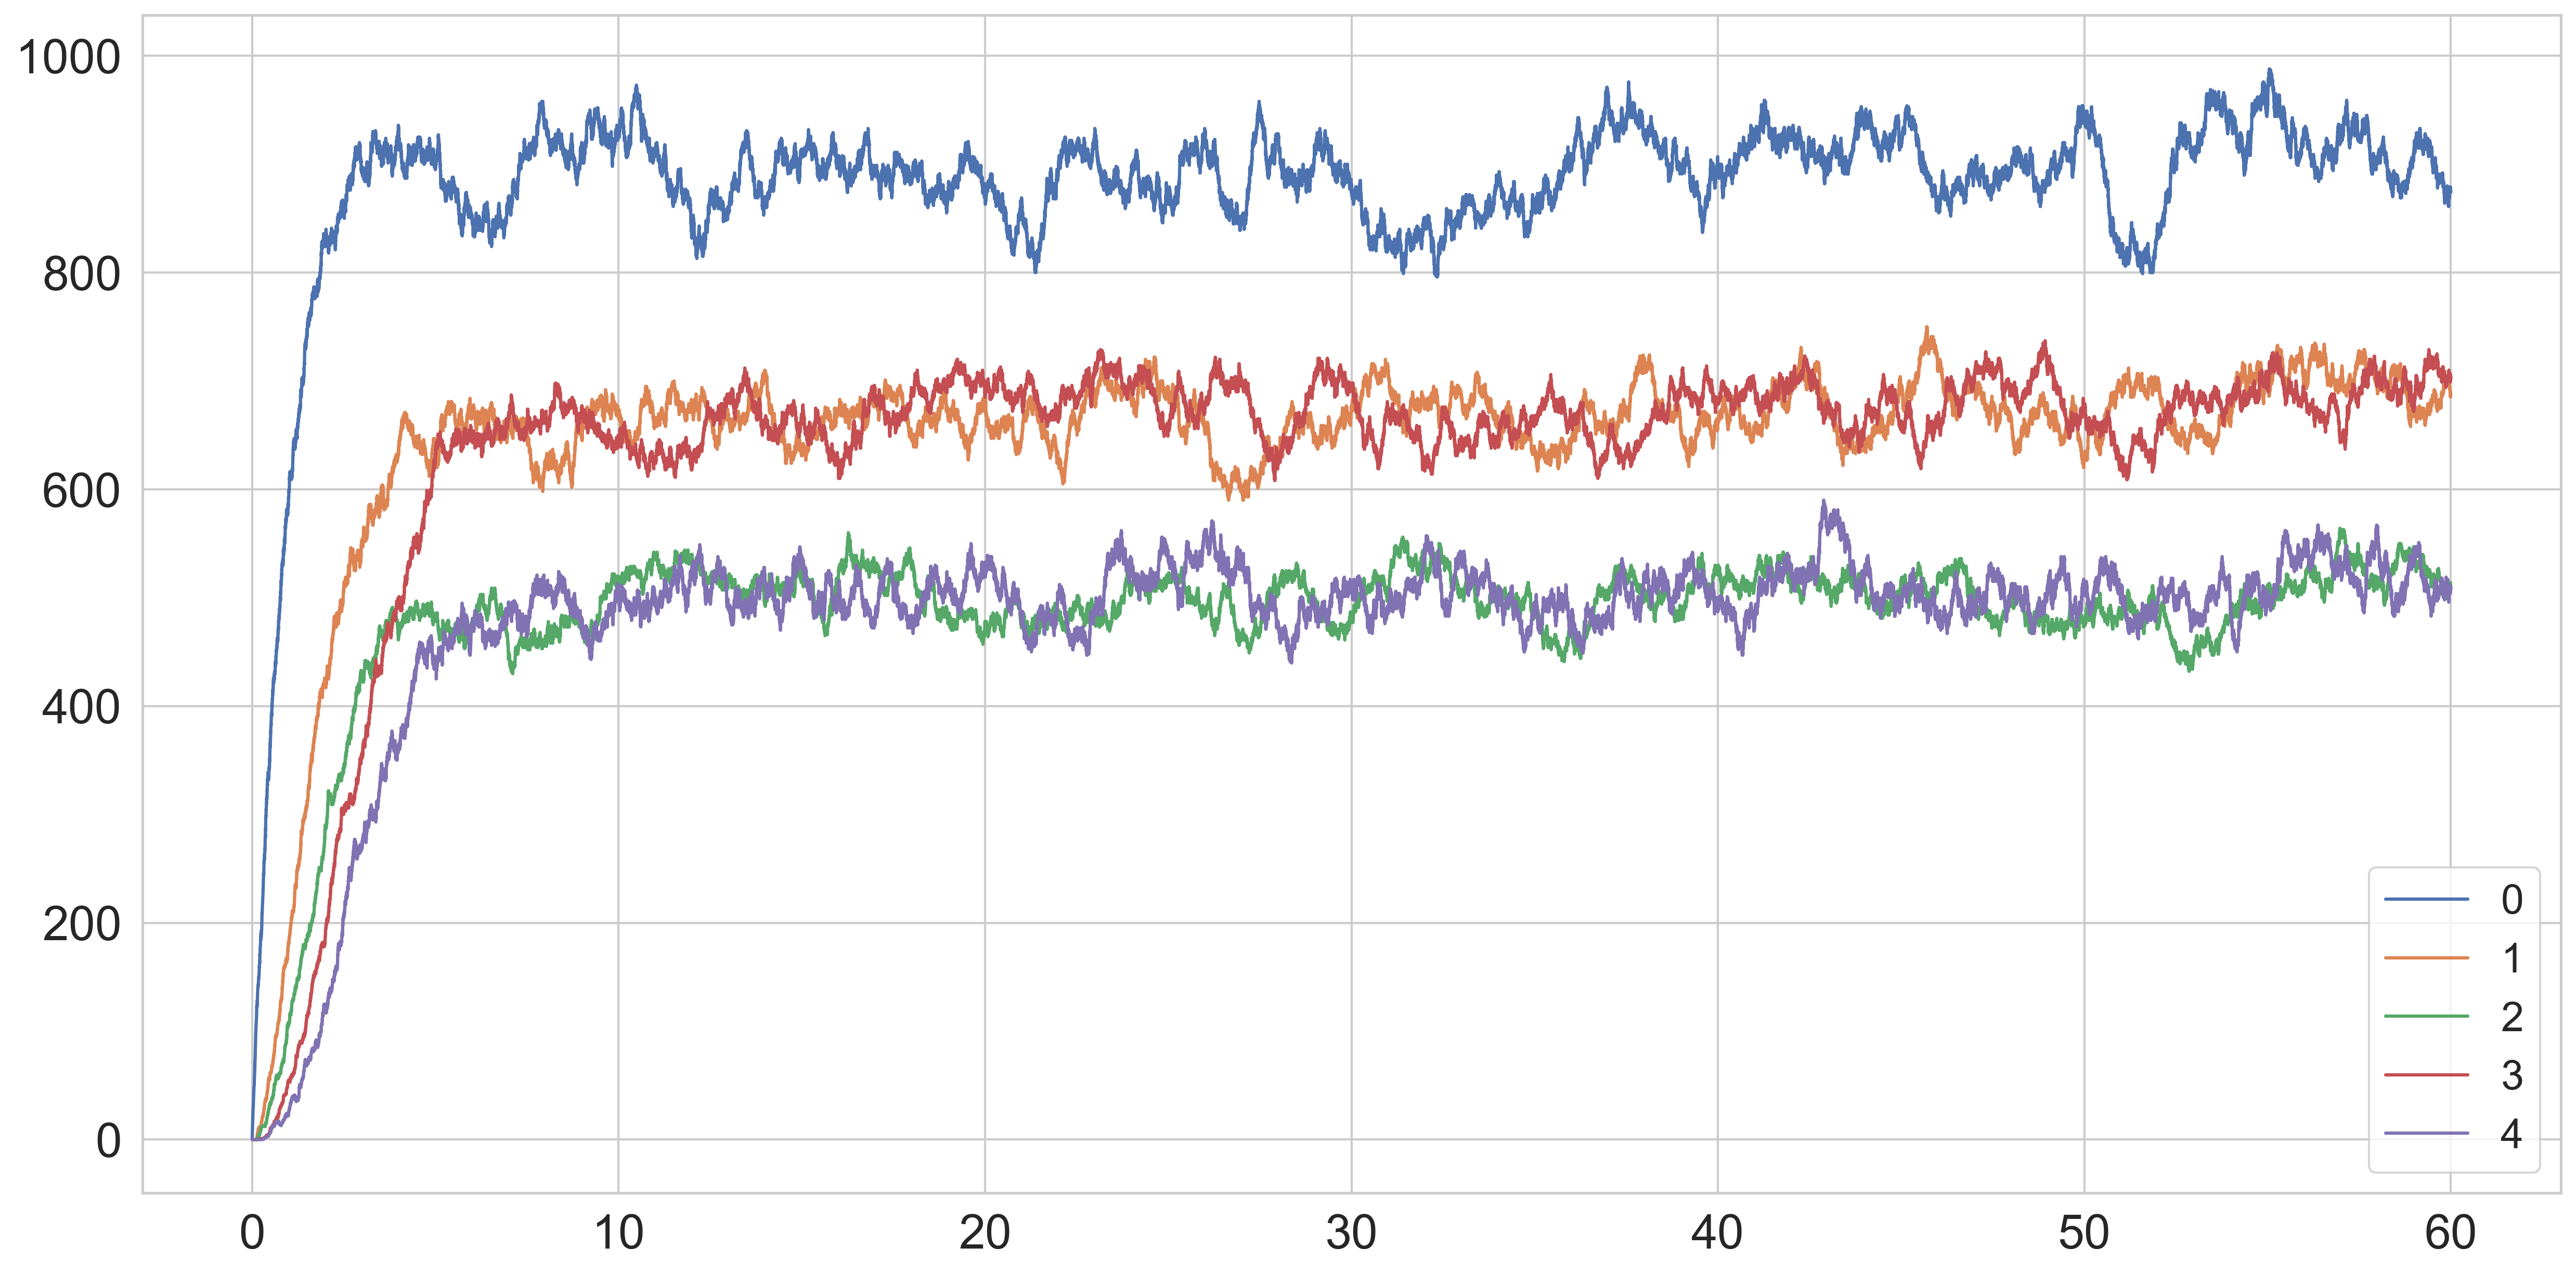

In [45]:
n_p,s_o_t,t_t= sim_proportional_fixed(1000,True)
sim_rappr(s_o_t,t_t)

The largest input rate that the system can handle without blowing up is inifinite

**b) Fixed rate:**

**Simulate the system for 60 time units and plot the evolution of number of particles in each node over time.What is the largest input rate that the system can handle without blowing up? Why is this different from the other case? (each node i will instead pass along particles with a fixed rate $\omega_i$)**

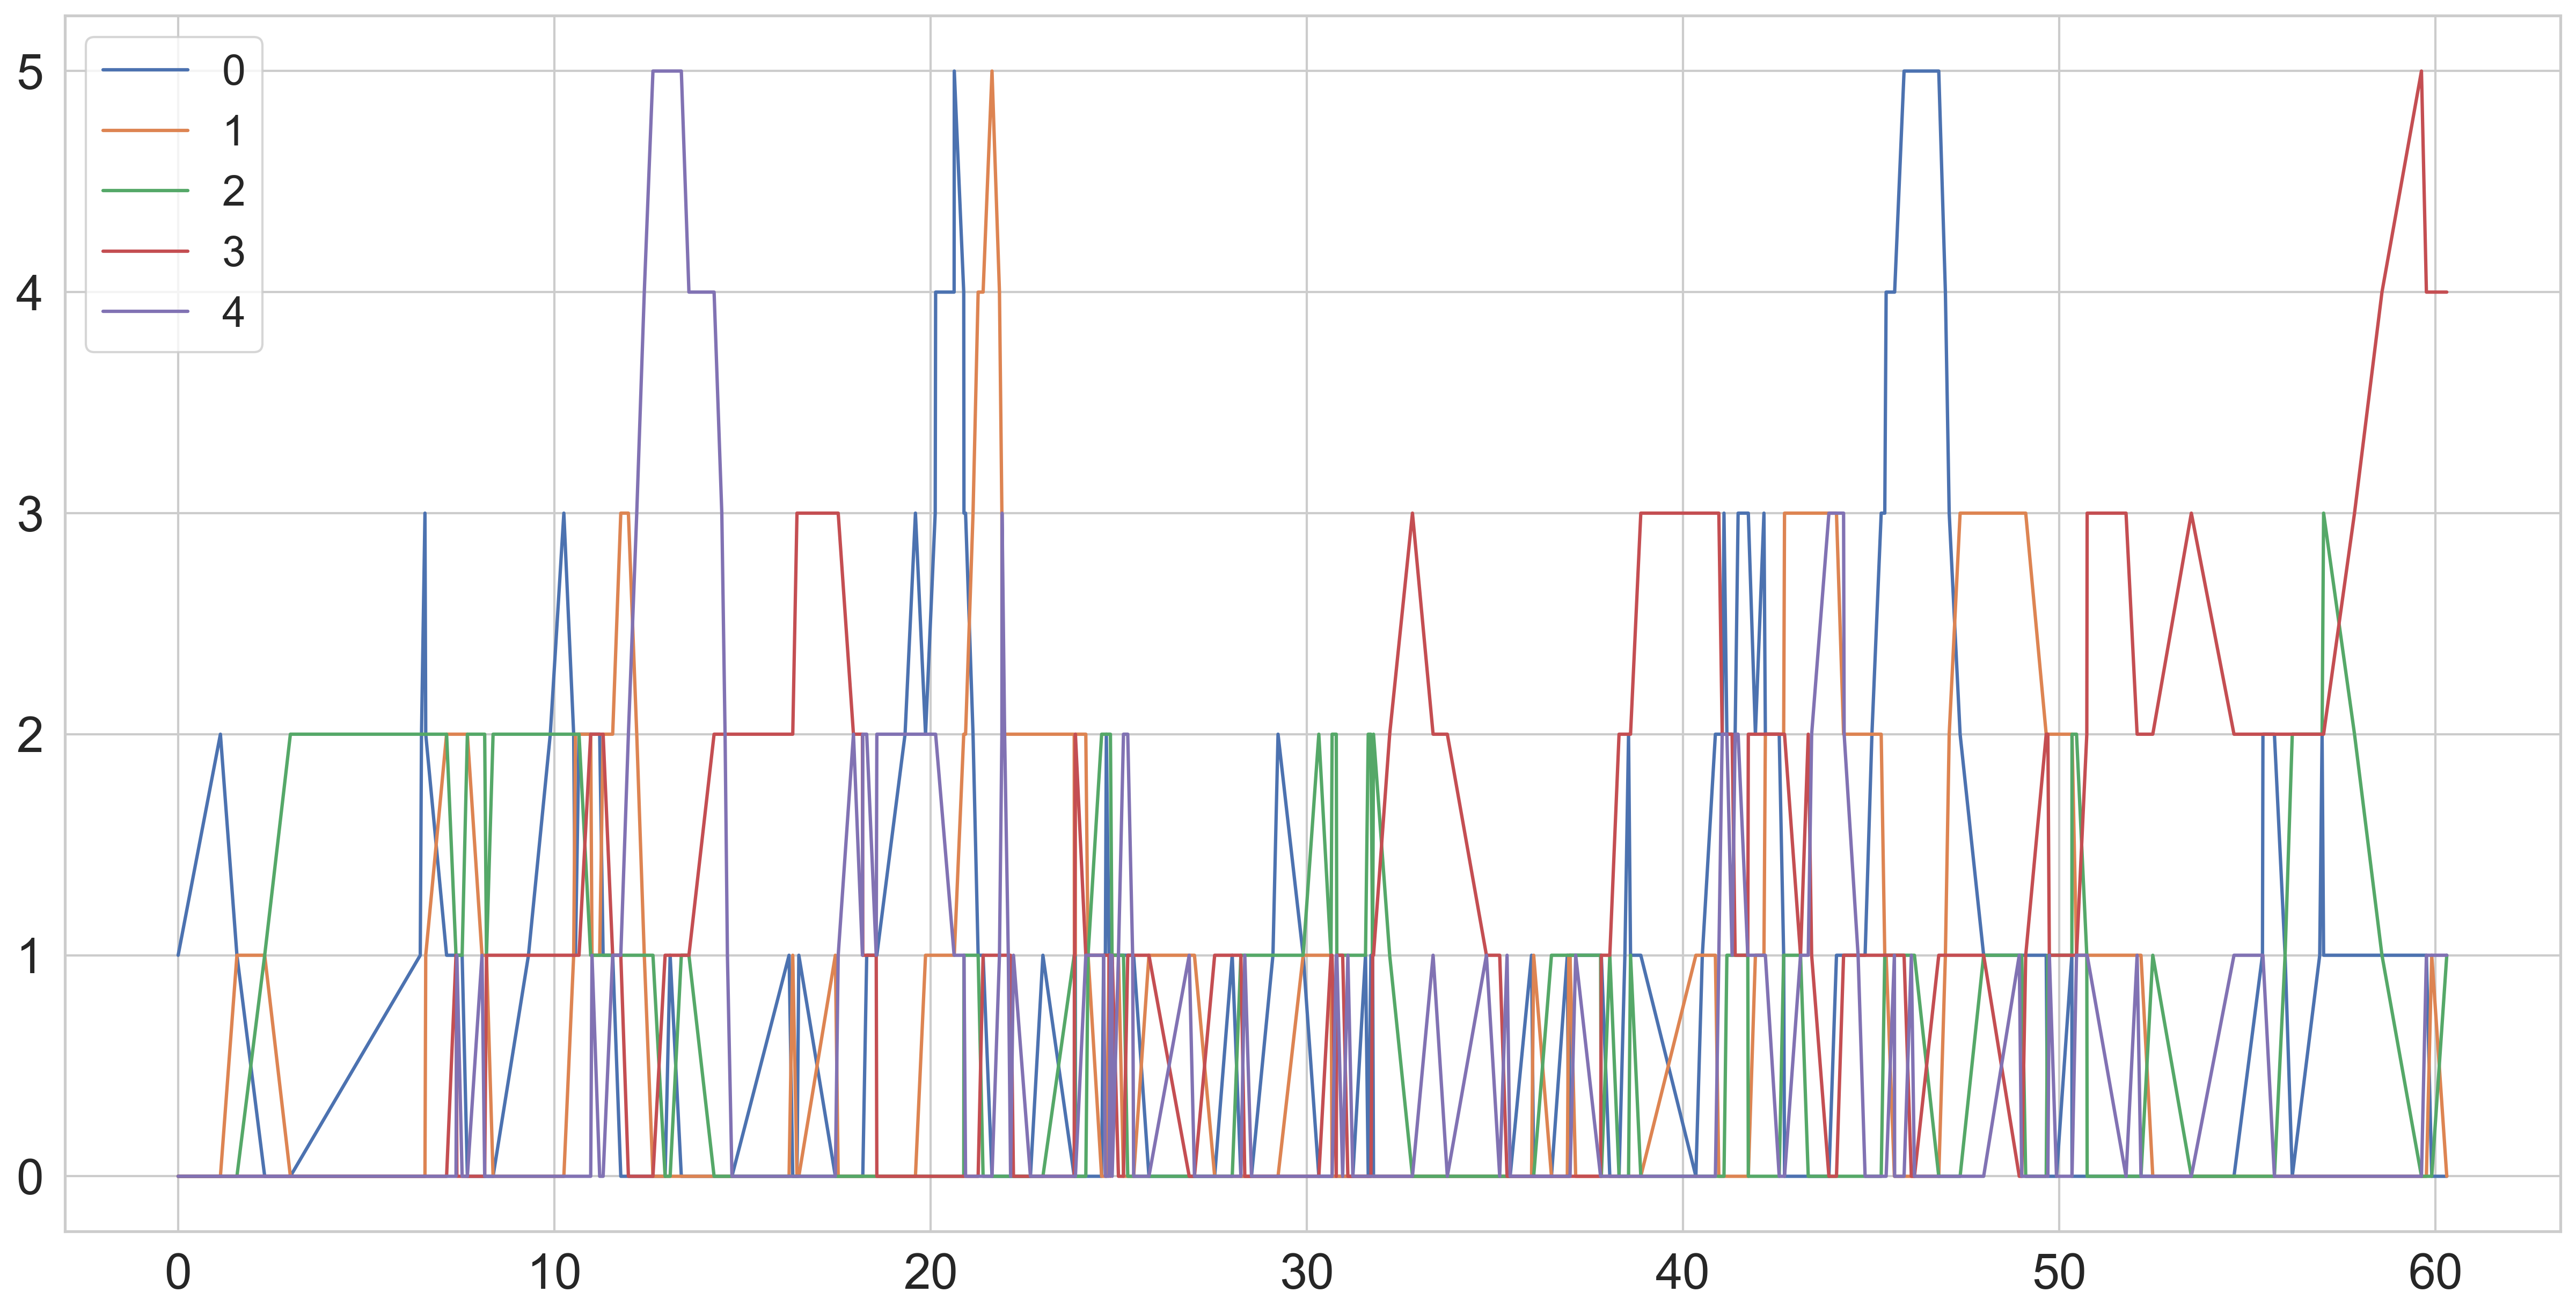

In [46]:
n_p,s_o_t,t_t= sim_proportional_fixed(1, False)
sim_rappr(s_o_t,t_t)

In [47]:
s_o_t

array([[1, 0, 0, 0, 0],
       [2, 0, 0, 0, 0],
       [1, 1, 0, 0, 0],
       ...,
       [1, 0, 0, 4, 1],
       [0, 1, 0, 4, 1],
       [0, 0, 1, 4, 1]])

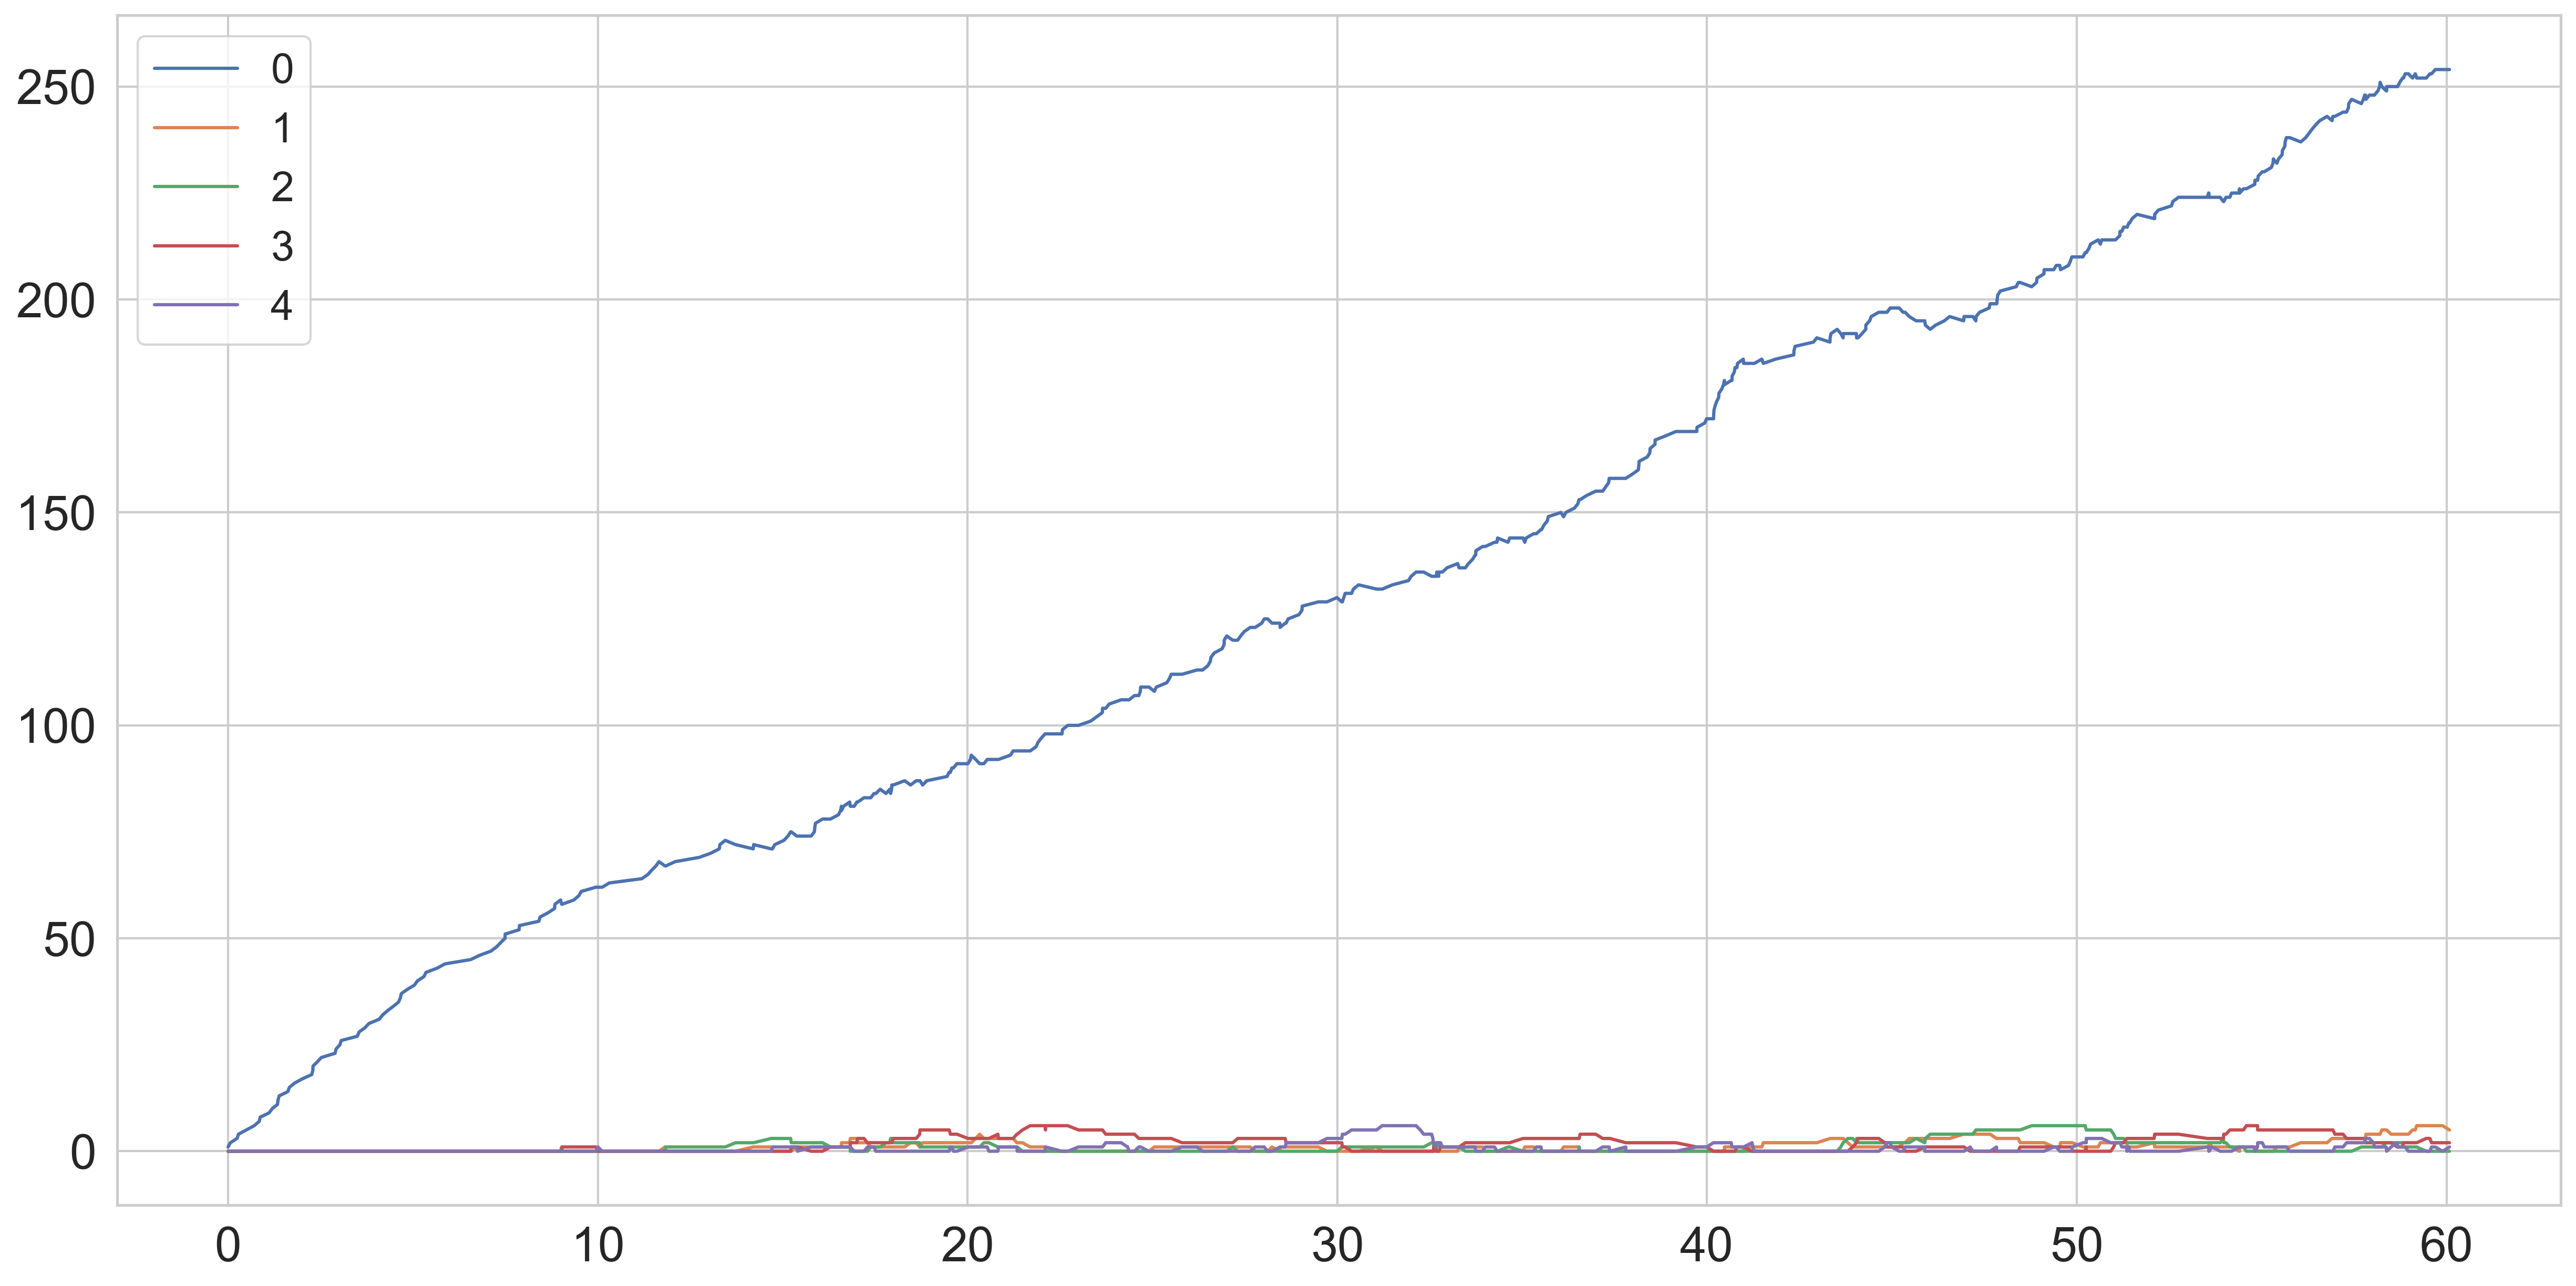

In [48]:
n_p,s_o_t,t_t= sim_proportional_fixed(5, False)
sim_rappr(s_o_t,t_t)

In [50]:
s_o_t

array([[  1,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0],
       [  3,   0,   0,   0,   0],
       ...,
       [254,   6,   0,   2,   1],
       [254,   6,   0,   2,   0],
       [254,   5,   0,   2,   1]])

In this case the largest input rate that the system can handle without blowing up is only 1 this is due to the fact that, while before it was also considered the number of particles present in the node now the rate is fixed. Since the selected node from which the particles depart is the node with the minor $t_{next}$, and since the t_next of o' is equal to $\frac{-ln(u)}{input_{rate}}$ while that of o is equal to $\frac{-ln(u)}{1.125}$, if the input rate over the value of 1.125 the network is no longer able to handle the incoming particles. As the node o represents our bottleneck.